In [1]:
import symflow as sf
from symflow.nodes import Datanode, Subnetnode
import numpy as np
from sklearn.preprocessing import MinMaxScaler
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def split_o_h(data, n_mol, n_o_orb, n_h_orb):
    
    data_o = np.zeros([data.shape[0], n_mol, n_o_orb])
    data_h = np.zeros([data.shape[0], n_mol*2, n_h_orb])
    
    data = data.reshape(data.shape[0], n_mol, -1)
    
    data_o[:,:,:] = data[:,:,:n_o_orb]
    
    for i in range(n_mol):
        data_h[:,i,:] = data[:,i,n_o_orb:n_o_orb + n_h_orb]
        data_h[:,i+n_mol,:] = data[:,i,n_o_orb+n_h_orb:]
    return data_o, data_h

In [3]:
def build_nodes(data_o, data_h, y, scaler_o, scaler_h):
    
    dnodes = []
    snodes = []
    
    for i in range(data_o.shape[1]):
        dnodes.append(Datanode(data_o[:,i,:],y, scaler_o))
        dnodes.append(Datanode(data_h[:,2*i,:], scaler = scaler_h))
        dnodes.append(Datanode(data_h[:,2*i + 1,:], scaler = scaler_h))
        snodes.append(Subnetnode('mull_o',1))
        snodes.append(Subnetnode('mull_h',1))
        snodes.append(Subnetnode('mull_h',1))
    
    for d,s in zip(dnodes,snodes):
        d >> s >> dnodes[0]
        
    return dnodes
    

In [4]:
mono_o, mono_h = split_o_h(np.genfromtxt('../exchange_ml/data/processed/monomers/lda/M.dat',delimiter = ','),
                           1,26,10)
dimer_o, dimer_h = split_o_h(np.genfromtxt('../exchange_ml/data/processed/dimers/lda/M.dat',delimiter = ','),
                           2,26,10)
trimer_o, trimer_h = split_o_h(np.genfromtxt('../exchange_ml/data/processed/trimers/lda/M.dat',delimiter = ','),
                           3,26,10)

all_o = np.concatenate([mono_o.reshape(-1,26),dimer_o.reshape(-1,26),trimer_o.reshape(-1,26)])
all_h = np.concatenate([mono_h.reshape(-1,10),dimer_h.reshape(-1,10),trimer_h.reshape(-1,10)])
scaler_o = MinMaxScaler(copy = False)
scaler_h = MinMaxScaler(copy = False)
scaler_o.fit(all_o);
scaler_h.fit(all_h);
scalers = [scaler_o, scaler_h]

In [5]:
mono_targets = np.genfromtxt('../exchange_ml/data/processed/monomers/gga/energies_siesta.dat') - \
                np.genfromtxt('../exchange_ml/data/processed/monomers/lda/energies_siesta.dat') 
monomean = np.mean(mono_targets)

mono_targets -= monomean
dimer_targets = np.genfromtxt('../exchange_ml/data/processed/dimers/gga/energies_siesta.dat') - \
                np.genfromtxt('../exchange_ml/data/processed/dimers/lda/energies_siesta.dat') 
dimer_targets -= monomean * 2
trimer_targets = np.genfromtxt('../exchange_ml/data/processed/trimers/gga/energies_siesta.dat') - \
                np.genfromtxt('../exchange_ml/data/processed/trimers/lda/energies_siesta.dat') 
trimer_targets -= monomean * 3

In [6]:
nodes_mono = build_nodes(mono_o, mono_h, mono_targets, *scalers)
nodes_dimer = build_nodes(dimer_o, dimer_h, dimer_targets, *scalers)
nodes_trimer = build_nodes(trimer_o, trimer_h, trimer_targets, *scalers)


No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this dataset.
No dataset contained yet, initializing node with this d

In [7]:
network = sf.Graph(nodes_mono + nodes_dimer + nodes_trimer)

In [8]:
network.connect_backwards()

In [9]:
network.train(step_size=0.001,max_steps=20000)

Connecting mull_o to Datanode
Connecting mull_h to Datanode
Connecting mull_h to Datanode
Sharing variables
Connecting mull_o to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_o to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_o to Datanode
Sharing variables
Connecting mull_o to Datanode
Sharing variables
Connecting mull_h to Datanode
Sharing variables
Connecting mull_o to Datanode
Sharing variables
Step: 0
Training set cost:
0: 25.79705810546875
1: 12.823004722595215
2: 39.10169219970703
Total: 48.56809616088867
Validation set cost:
0: 25.812606811523438
1: 12.8201866

KeyboardInterrupt: 

Connecting mull_h to Datanode
Connecting mull_h to Datanode
Connecting mull_o to Datanode
Connecting mull_h to Datanode
Connecting mull_h to Datanode
Connecting mull_o to Datanode
Connecting mull_h to Datanode
Connecting mull_o to Datanode
Connecting mull_h to Datanode
Connecting mull_h to Datanode
Connecting mull_o to Datanode
Connecting mull_h to Datanode
Connecting mull_o to Datanode
Connecting mull_h to Datanode
Connecting mull_h to Datanode
Connecting mull_h to Datanode
Connecting mull_h to Datanode
Connecting mull_o to Datanode


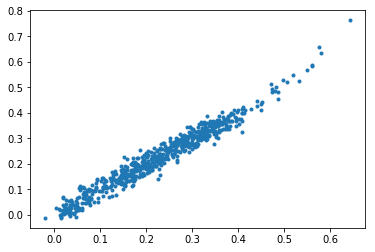

In [15]:
plot(network.get_logits()[2],nodes_trimer[0].y_train, ls ='', marker = '.')